# `mkregmap`

This script reads in a stack of regions (1 to N) and labels the pixels in the output map based on which region they belong to. In the case of overlaps, the last (highest N) is used.

In [1]:
ciaover 
echo Today is `date`

CIAO 4.11 Wednesday, December  5, 2018
  bindir      : /export/ciao-4.11/bin
  CALDB       : 4.8.2
Today is Wed Jan 23 08:29:18 EST 2019


In [2]:
source display_map.sh

In [3]:
#/bin/rm -rf ./tmp
#mkdir ./tmp
ASCDS_WORK_PATH=`pwd`/tmp

## Example 1, regular polar grid

In [4]:
dmstat smimg.fits cen- 
px=`stk_read_num ")dmstat.out_max_loc" 1 echo+`
py=`stk_read_num ")dmstat.out_max_loc" 2 echo+`

CONVOLVE
    min:	0.0066826618277 	      @:	( 4438.5 4550.5 )
    max:	126.03153992 	      @:	( 4274.5 3954.5 )
   mean:	6.624006713 
  sigma:	10.931784032 
    sum:	486056.36459 
   good:	73378 
   null:	59846 


In [5]:
mkregmap img.dss.fits out=pie.map bin=pie.img coord=sky clob+ \
  regions="circle(${px},${py},10);pgrid(${px},${py},10:1000:10,0:360:30)"

mkregmap
          infile = img.dss.fits
         regions = circle(4274.5,3954.5,10);pgrid(4274.5,3954.5,10:1000:10,0:360:30)
         outfile = pie.map
          binimg = pie.img
           coord = sky
         clobber = yes
         verbose = 1
            mode = ql



In [6]:
### map2reg pie.map pie.reg clob+

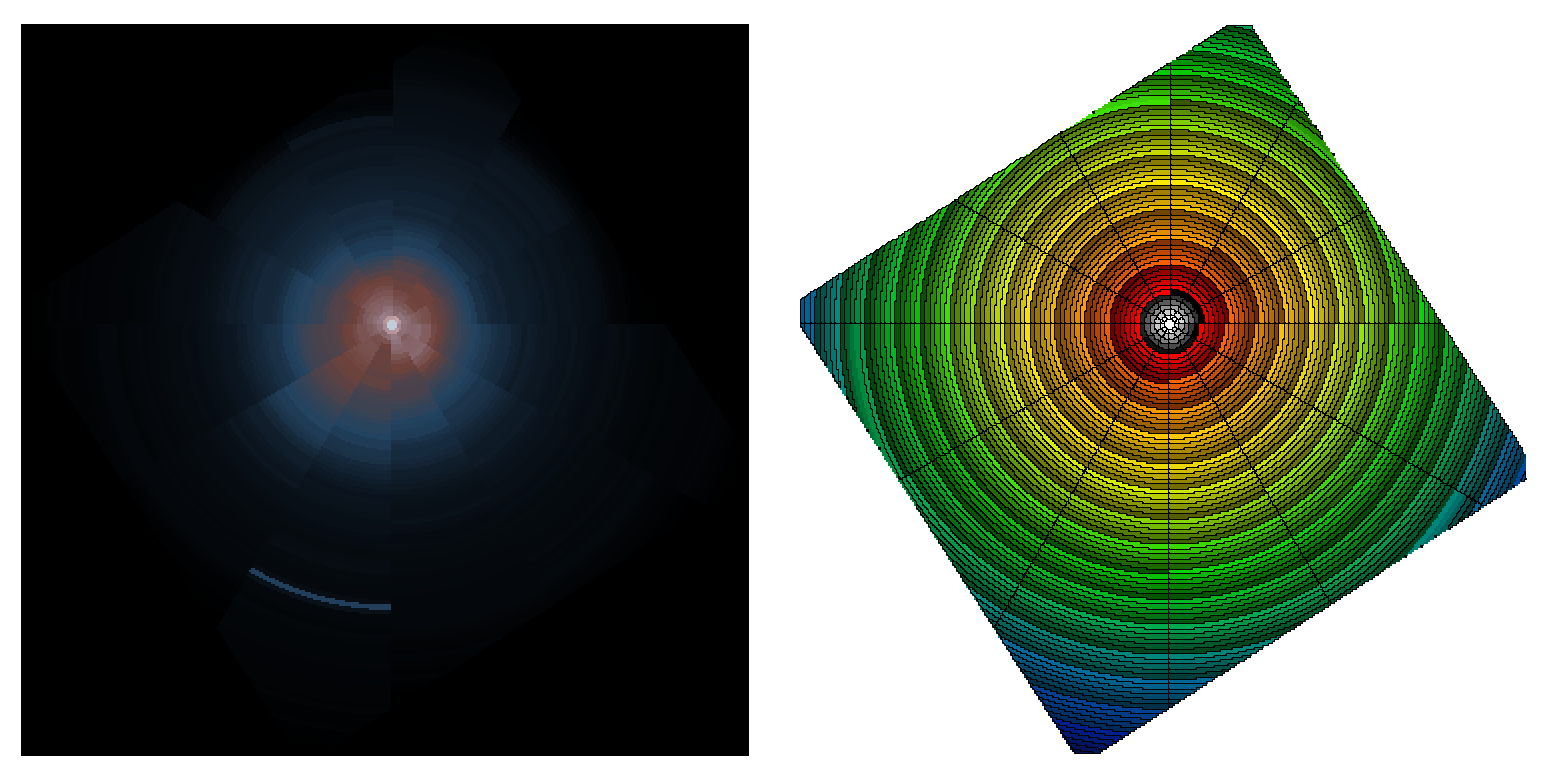

In [7]:
display_map pie.img pie.map pie.png pie.reg

Again, this isn't really _adaptive_ in the same was as other algorithms; but is shown here to illustrate the use of
stacks of regions using the `pgrid` syntax.

### Example 2, isophot-ellipse

In this example we use [`dmellipse`](http://cxc.cfa.harvard.edu/ciao/ahelp/dmellipse.html) to create a set of ellipses which enclose from 5% to 100% of the counts in the image in 2.5% increments.  These ellipses are then used as 
input to `mkregmap`


In [8]:
dmellipse infile=img.fits outfile=ellipses.fits  \
  fraction="lgrid(0.05:1.0:0.025)" shape=ellipse clob+ step=20 verb=1

# We need to reverse order so that smallest fraction is last region in file
# since the last region a pixel is used when there are overlaps.
dmsort ellipses.fits ellipses_sort.fits -component clob+

In [9]:
mkregmap infile=img.dss.fits outfile=ellipse.map bin=ellipse.img clob+ \
  regions='ellipses_sort.fits[#row=igrid(1:100:1)]'

mkregmap
          infile = img.dss.fits
         regions = ellipses_sort.fits[#row=igrid(1:100:1)]
         outfile = ellipse.map
          binimg = ellipse.img
           coord = sky
         clobber = yes
         verbose = 1
            mode = ql



In [10]:
### map2reg ellipse.map ellipse.reg clob+

In [11]:
dmcopy "ellipse.reg[shape=Polygon]" ellipse_a.reg clob+

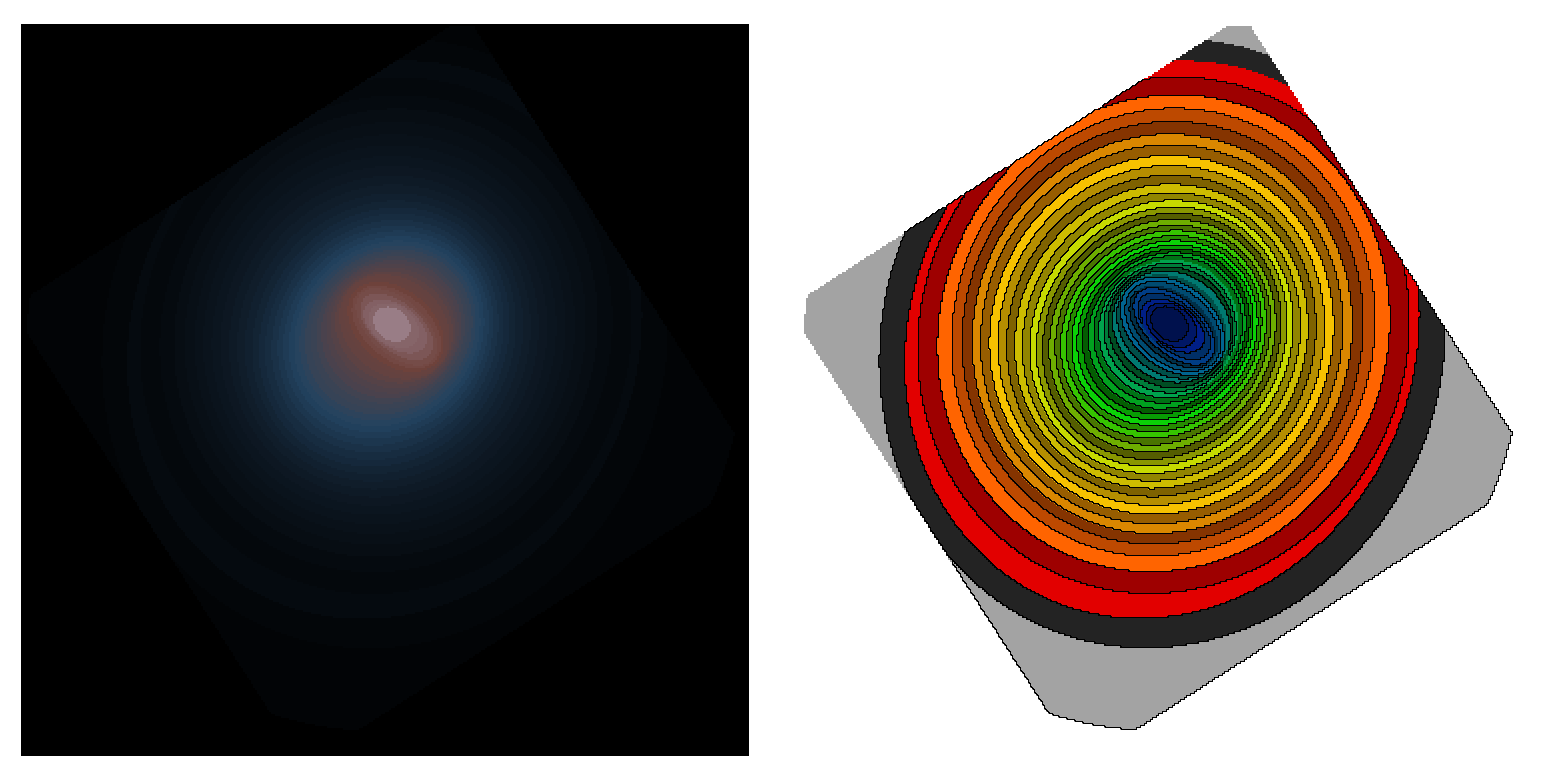

In [12]:
display_map ellipse.img ellipse.map ellipse.png ellipse_a.reg

We sorted the `dmellipse` output file so that the inner ellipses (smaller fraction) are last.
